In [2]:
# common imports
import os
import numpy as np
import datetime
import time
import matplotlib.pylab as plt
import pandas as pd
from glob import glob
from pathlib import Path
from functools import partial
import plotly.express as px

from sklearn.model_selection import train_test_split

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# prevent VRAM occupied
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# load tensorboard extension
%reload_ext tensorboard

In [12]:
# Constants
SEED =42
# minimum number of cases for each diagnosis/finding label (of 14)
MIN_CASES  = 1000
MIN_CASES_FLAG = True
IMAGE_SIZE = (224,224)
IMAGE_SHAPE = (224,224,3)
BATCH_SIZE = 32
SHUFFLE = True
TARGET_WIDTH= 224
TARGET_HEGIHT =224
NUM_CLASSES = 15 # number of ClassesNUM
NUM_EPOCHS = 5
#PRETRAINED_MODELS = ['ResNet50V2', 'MobileNetV2', 'VGG16', 'InceptionV3' ,'DenseNet121'] # pretrained modelspretrained_models = ['ResNet50V2', 'MobileNetV2', 'VGG16', 'InceptionV3'] # pretrained modelspr
PRETRAINED_MODELS = ['ResNet50V2']
log_folder = 'logs' # logs folder

In [13]:
nih_xrays_df = pd.read_csv('../data/processed/prepared_data_entry_2017.csv')

In [14]:
nih_xrays_df.describe()

,follow_up_num,patient_id,age,image_width,image_height,x_spacing,y_spacing,Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,NoFinding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,...,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,0.103101,0.024763,0.041631,...,0.022443,0.015040,0.002025,0.177433,0.051550,0.538366,0.056474,0.030186,0.012756,0.047286
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,0.304092,0.155402,0.199745,...,0.148121,0.121711,0.044954,0.382037,0.221118,0.498528,0.230836,0.171100,0.112220,0.212252
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Get fourteen unique diagnosis
# It is a function that takes a series of iterables and returns one iterable
# The asterisk "*" is used in Python to define a variable number of arguments. 
# The asterisk character has to precede a variable identifier in the parameter list 
from itertools import chain
all_labels = np.unique(list(chain(*nih_xrays_df['finding_label'].map(lambda x: x.split('|')).tolist())))
# remove the empty label
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'NoFinding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [16]:
nih_xrays_train_df = pd.read_csv('../data/processed/prepared_train_data_entry_2017.csv')
nih_xrays_valid_df = pd.read_csv('../data/processed/prepared_valid_data_entry_2017.csv')

In [17]:
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
image_data_gen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True, #Boolean. Set each sample mean to 0.
    samplewise_std_normalization = False, #Boolean. Divide each input by its std.
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    horizontal_flip = True, #Boolean. Randomly flip inputs horizontally.
    vertical_flip = False,  #Boolean. Randomly flip inputs vertically.
    zca_whitening=False,  # apply ZCA whitening
    height_shift_range= 0.05, #float: fraction of total height, if < 1, or pixels if >= 1.
    width_shift_range=0.1,  #float: fraction of total height, if < 1, or pixels if >= 1.
    rotation_range=20, #Int. Degree range for random rotations. 0 -180 degrees
    shear_range = 0.1, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    fill_mode = 'nearest', #One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. 
    zoom_range=0.15) #Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]

In [18]:
#Takes the dataframe and the path to a directory + generates batches.
train_generator = image_data_gen.flow_from_dataframe(
            dataframe=nih_xrays_train_df,
            directory=None, #string, path to the directory to read images from. 
                            #If None, data in x_col column should be absolute paths.
            x_col='path', #string, column in dataframe that contains the filenames (or absolute paths if directory is None).
            y_col='finding_label', #string or list, column/s in dataframe that has the target data.
    
            class_mode="categorical", #one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical". 
                              # Mode for yielding the targets: "raw": numpy array of values in y_col column(s),
            classes=all_labels,
            #color_mode='grayscale',
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE,
            seed=SEED,
            target_size= IMAGE_SIZE)

#Takes the dataframe and the path to a directory + generates batches.
valid_generator = image_data_gen.flow_from_dataframe(
            dataframe=nih_xrays_valid_df,
            directory=None, #string, path to the directory to read images from. 
                            #If None, data in x_col column should be absolute paths.
            x_col='path', #string, column in dataframe that contains the filenames (or absolute paths if directory is None).
            y_col='finding_label', #string or list, column/s in dataframe that has the target data.
    
            class_mode="categorical", #one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical". 
                              # Mode for yielding the targets: "raw": numpy array of values in y_col column(s),
            classes=all_labels,
            #color_mode='grayscale',
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE,
            seed=SEED,
            target_size= IMAGE_SIZE)
test_X, test_Y = next(image_data_gen.flow_from_dataframe( nih_xrays_valid_df,
                            directory = None,    
                            x_col = 'path',
                            y_col = 'Finding Labels', 
                            seed =42,
                            target_size = IMAGE_SIZE,
                            class_mode='categorical',
                            #classes = all_labels,
                            #save_to_dir='../data/interm/test',
                            #validation =0.2,
                            #color_mode = 'grayscale',
                            batch_size = 32)) # one big batch

Found 73079 validated image filenames belonging to 15 classes.
Found 18233 validated image filenames belonging to 15 classes.


KeyError: 'Finding Labels'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


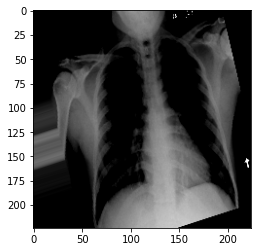

In [ ]:
x, y = train_generator.__getitem__(2)
plt.imshow(x[0])
print(y[0])

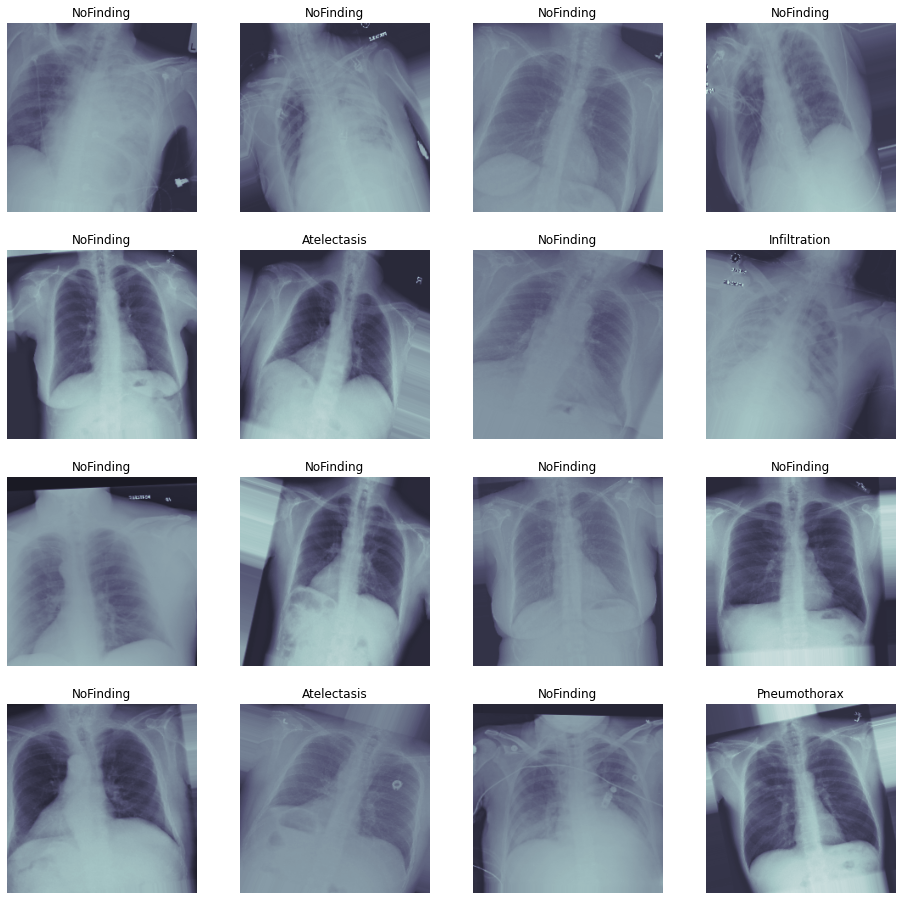

In [ ]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [19]:

def get_base_model(model_name :str = 'resenet50v2', freeze_layers:bool = False):
    """ returns pretrained model

    Args:
        model_name (str): model_name values pretrained_models = ['ResNet50V2', 'MobileNetV2', 'VGG16']
    """
    if model_name == 'ResNet50V2' :
        print(f"Downloading ResNet50V2")
        base_model = tf.keras.applications.ResNet50V2(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    elif model_name == 'MobileNetV2' :
        print(f"Downloading MobileNetV2")
        base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    elif model_name == 'VGG16' :
        print(f"Downloading VGG16")
        base_model = tf.keras.applications.VGG16(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    elif model_name == 'DenseNet121' :
        print(f"Downloading DenseNet121")
        base_model = tf.keras.applications.DenseNet121(input_shape=None,
                                                      input_tensor=None,
                                               include_top=False,
                                               weights='imagenet')
    if freeze_layers == True:
        for layer in base_model.layers:
            layer.trainable = False
            #assert layer.trainable is False
    
    return base_model


def compile_classifier(model, learning_rate, optimizer = 'Adam'):
    """[summary]

    Args:
        model ([tensorflow.keras.Model]): classifier model
        learning_rate ([float]): [description]
        optimizer ([tensorflow.keras.optimizers]): optimizer
    """
    if optimizer == 'Adam':
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            amsgrad=True,
            name="Adam"
            )

    elif optimizer == 'Adagrad':
        optimizer=tf.keras.optimizers.Adagrad(
            learning_rate=learning_rate,
            initial_accumulator_value=0.1,
            epsilon=1e-07,
            name="Adagrad")
    
    elif optimizer == 'NestrovSGD':
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=0.01, 
            momentum=0.9, 
            nesterov=True, 
            name="SGD")

    
    model.compile(optimizer = optimizer,
                  #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  #loss =tf.keras.losses.CategoricalCrossentropy(),
                  #loss=get_weighted_loss(pos_weights, neg_weights),
                  #metrics=['accuracy']
                  loss = tf.keras.losses.binary_crossentropy,
                  #metrics =['binary_accuracy', 'mae', 'auc']
                  metrics = [keras.metrics.MAE, 
                             keras.metrics.Accuracy(),
                             keras.metrics.BinaryAccuracy(threshold=0.65),
                             keras.metrics.FalseNegatives(),
                             keras.metrics.FalsePositives(), 
                             keras.metrics.AUC(multi_label=True)]
                  )
    
    return model

def get_base_model_with_new_toplayer(base_model, 
                                     freeze_layers: bool = False, 
                                     num_classes: int = NUM_CLASSES,
                                     learning_rate: float = 0.01):
    """ add a classifier

    Args:
        base_model ([keras.Model]): base_model
        num_classes ([int]) : number classes
    """
    base_model = get_base_model(base_model,freeze_layers)
    head_model = base_model.output
    head_model = keras.layers.Flatten(name="flatten")(head_model)
    # head_model = keras.layers.Dense(256, activation="relu")(head_model)
    # head_model = keras.layers.Dropout(0.3)(head_model)
    # head_model = keras.layers.Dense(128, activation="relu")(head_model)
    # head_model = keras.layers.Dropout(0.3)(head_model)
    # head_model = keras.layers.Dense(64, activation="relu")(head_model)
    head_model = keras.layers.Dense(num_classes,activation='sigmoid')(head_model)
    model = keras.Model(inputs=base_model.input, outputs=head_model)
    model = compile_classifier(model, learning_rate)
    return model



def fine_tune_model(model, learning_rate =0.00001, optimizer = 'Adam',  fine_tune_at_layer:int=100):
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[fine_tune_at_layer:]:
        layer.trainable =  True
    compile_classifier(model, learning_rate = learning_rate, optimizer=optimizer)
    return model

#callback setup
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

checkpoint_path = 'xray_class_weights.best.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

callbacks = [checkpoint, early, reduce_lr]


def fit_model(model,train_ds,
    validation_ds, 
    num_epochs: int = NUM_EPOCHS, batch_size: int = BATCH_SIZE):
    history = model.fit(train_ds,
                    epochs=num_epochs,
                    validation_data=validation_ds,
                    steps_per_epoch = len(train_ds)//batch_size,#steps_per_epoch = 100, 
                    validation_steps=len(validation_ds)//batch_size, #validation_steps= 25, 
                    callbacks=callbacks)
    return history


def train_validate_classifier(model_name, train_generator, valid_generator, learning_rate:float = 0.0001, fine_tune_at_layer:int = 100):
    
    
    model = get_base_model_with_new_toplayer(model_name,freeze_layers = False,
        num_classes = NUM_CLASSES)

    
    print("\n")
    print(f'{model_name} Training and Validation: ')
    
    history = fit_model(model, train_generator, 
        valid_generator, 
        num_epochs=NUM_EPOCHS)

    print(f'{model_name} Accuracy and Loss plots')
    #plot_accuracy_and_loss(history)
    
    
    print("\n")
    #fine_tune model_name
    model_ft = fine_tune_model(model,learning_rate,optimizer='Adam',fine_tune_at_layer=fine_tune_at_layer)
    #print(model_ft.summary())

    
    print("\n")
    print(f'Fine-Tuned {model_name} Training and Validation: ')
    history_fine = fit_model(model_ft, train_generator, 
        valid_generator, 
        num_epochs=NUM_EPOCHS)
    print(f'Fine-Tuned {model_name} Accuracy and Loss plots')
    #plot_accuracy_and_loss(history_fine)
    
    model_ft.save('my-model')


In [20]:
pretrained_base_model = PRETRAINED_MODELS[0]
learning_rate = 0.01
fine_tune_at_layer = 178
train_validate_classifier(pretrained_base_model,train_generator, valid_generator, learning_rate,fine_tune_at_layer)



ResNet50V2 Training and Validation: 
Epoch 1/5


ResourceExhaustedError: in user code:

    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/keras/engine/training.py:791 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:522 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:628 apply_gradients
        self._create_all_weights(var_list)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:815 _create_all_weights
        self._create_slots(var_list)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:117 _create_slots
        self.add_slot(var, 'm')
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:901 add_slot
        weight = tf.Variable(
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:268 __call__
        return cls._variable_v2_call(*args, **kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:250 _variable_v2_call
        return previous_getter(
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3547 creator
        return next_creator(**kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3547 creator
        return next_creator(**kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3547 creator
        return next_creator(**kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:746 variable_capturing_scope
        v = UnliftedInitializerVariable(
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:270 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:294 __init__
        initial_value = initial_value()
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:145 __call__
        return tf.zeros(shape, dtype)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2915 wrapped
        tensor = fun(*args, **kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2976 zeros
        output = fill(shape, constant(zero, dtype=dtype), name=name)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:240 fill
        result = gen_array_ops.fill(dims, value, name=name)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py:3368 fill
        _ops.raise_from_not_ok_status(e, name)
    /home/jay/Temple/apps/envs/env/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:6941 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]


NameError: name 'image_data_gen' is not defined